In [4]:
import numpy as np  #numpy
import pandas as pd  #pandas
import tensorflow as tf
#System libraries
import glob #The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell

# #Map plotting 
# import folium #Interactive Maps viz

# #Plotting
# import seaborn as sns
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

#math operations lib 
import math
from math import pi

#date manipulation 
import datetime as dt

# #Missing data detector lib
# import missingno as mn

# #Impute missing data
# from sklearn.preprocessing import Imputer 

# #Deep learning with keras
# from keras import backend as K
# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Dropout

# #Splitting data to test and train 
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.linear_model import LogisticRegression
# from tensorflow import keras
# %matplotlib inline
# plt.style.use('seaborn-whitegrid')

# from mpl_toolkits.mplot3d import Axes3D
# from sklearn.preprocessing import StandardScaler
# from collections import Counter
# import time
# from datetime import datetime
# import collections
# import os # accessing directory structure
# import seaborn as sns
# from matplotlib.pyplot import rcParams

# from sklearn import linear_model

import re
import warnings
warnings.filterwarnings('ignore')

ad_operation_path = 'https://lwh-tenxun-test.oss-cn-shenzhen.aliyuncs.com/testA/ad_operation.csv'
ad_static_feature_path = 'https://lwh-tenxun-test.oss-cn-shenzhen.aliyuncs.com/testA/ad_static_feature.csv'
test_sample_path = 'https://lwh-tenxun-test.oss-cn-shenzhen.aliyuncs.com/testA/test_sample.csv'
Btest_sample_new_path = 'https://lwh-tenxun-test.oss-cn-shenzhen.aliyuncs.com/testA/Btest_sample_new.csv'


ad_operation = pd.read_csv(ad_operation_path,sep='\t',names=['ad_id','Change_time','Operation_type',
                                                             'Modify_field','value_after_operation'])
ad_static_feature = pd.read_csv(ad_static_feature_path,sep='\t',names=['ad_id','Creation_time','ad_account_id','Product_id',
                                                                       'Product_Types','ad_industry_id','ad_size'])
# test_sample = pd.read_csv(test_sample_path,sep='\t',names=['Sample_id','ad_id','Creation_time','ad_size','ad_industry_id','Product_Types',
#                                                            'Product_id','ad_account_id','Delivery_period','Crowd_orientation','ad_bid'])
# Btest_sample = pd.read_csv(Btest_sample_new_path,sep='\t',names=['Sample_id','ad_id','Creation_time','ad_size','ad_industry_id','Product_Types',
#                                                            'Product_id','ad_account_id','Delivery_period','Crowd_orientation','ad_bid'])

# test_sample['Creation_time'] = pd.to_datetime(test_sample['Creation_time'],unit='s')
# Btest_sample['Creation_time'] = pd.to_datetime(Btest_sample['Creation_time'],unit='s')

## 操作数据

In [5]:
ad_operation = ad_operation.drop_duplicates()
ad_operation = ad_operation[~ad_operation['Change_time'].isin([20190230000000])]
ad_operation = ad_operation.drop_duplicates(subset=['ad_id','Change_time','Operation_type','Modify_field'],keep = 'last' )

In [6]:
ad_operation['key'] = ad_operation.apply(lambda x:str(x['ad_id'])+'-'+str(x['Change_time'])+'-'+str(x['Operation_type']),axis = 1)

temp = ad_operation.pivot(index = 'key',columns='Modify_field',values='value_after_operation')
temp.rename(index = str,columns = {1:'ad_status',2:'ad_bid',3:'Crowd_orientation',4:'Delivery_period'},inplace = True)

ad_operation = ad_operation.drop_duplicates(subset=['ad_id','Change_time','Operation_type'],keep = 'last')

ad_operation = pd.merge(ad_operation,temp, how = 'left',left_on = 'key',right_on = 'key')

ad_operation.drop(['key','Modify_field','value_after_operation'],axis = 1,inplace = True)
ad_operation = ad_operation.sort_values(['ad_id','Change_time'])


In [7]:
ad_operation['ad_bid'] = ad_operation.groupby("ad_id").ad_bid.transform(lambda x: x.fillna(axis = 0,method = 'ffill'))
ad_operation['Crowd_orientation'] = ad_operation.groupby("ad_id").Crowd_orientation.transform(lambda x: x.fillna(axis = 0,method = 'ffill'))
ad_operation['Delivery_period'] = ad_operation.groupby("ad_id").Delivery_period.transform(lambda x: x.fillna(axis = 0,method = 'ffill'))

ad_operation['Change_time'] = pd.to_datetime(ad_operation.Change_time, format='%Y%m%d%H%M%S', errors='coerce')
ad_operation = ad_operation.rename(columns={'Change_time':'Creation_time'})

In [8]:
ad_operation.head()

,ad_id,Creation_time,Operation_type,ad_status,ad_bid,Crowd_orientation,Delivery_period
652311,31,NaT,2,NaN,100,area:11442,"281474976694272,281474976694272,28147497669427..."
652312,31,2019-03-13 19:52:07,1,0,100,area:11442,"281474976694272,281474976694272,28147497669427..."
227846,32,NaT,2,NaN,83,area:7572,"70368475742208,70368475742208,70368475742208,7..."
227847,32,2019-02-21 05:31:31,1,NaN,91,area:7572,"70368475742208,70368475742208,70368475742208,7..."
227848,32,2019-02-21 22:34:03,1,0,91,area:7572,"70368475742208,70368475742208,70368475742208,7..."


In [9]:
ad_operation['ad_status'] = ad_operation.ad_status.fillna(1)

In [10]:
ad_operation.shape  # 682246
ad_operation.head(10)

,ad_id,Creation_time,Operation_type,ad_status,ad_bid,Crowd_orientation,Delivery_period
652311,31,NaT,2,1,100,area:11442,"281474976694272,281474976694272,28147497669427..."
652312,31,2019-03-13 19:52:07,1,0,100,area:11442,"281474976694272,281474976694272,28147497669427..."
227846,32,NaT,2,1,83,area:7572,"70368475742208,70368475742208,70368475742208,7..."
227847,32,2019-02-21 05:31:31,1,1,91,area:7572,"70368475742208,70368475742208,70368475742208,7..."
227848,32,2019-02-21 22:34:03,1,0,91,area:7572,"70368475742208,70368475742208,70368475742208,7..."
227849,32,2019-02-22 05:31:39,1,1,91,area:7572,"70368475742208,70368475742208,70368475742208,7..."
227850,32,2019-02-22 21:52:04,1,0,91,area:7572,"70368475742208,70368475742208,70368475742208,7..."
227851,32,2019-02-23 05:31:42,1,1,91,area:7572,"70368475742208,70368475742208,70368475742208,7..."
227852,32,2019-02-23 10:41:13,1,0,91,area:7572,"70368475742208,70368475742208,70368475742208,7..."
227853,32,2019-02-24 12:11:14,1,1,91,area:7572,"70368475742208,70368475742208,70368475742208,7..."


In [ ]:
# ad_operation.to_csv('ad_operation_new.csv',index = False)

## 静态数据

In [11]:
ad_static_feature['Creation_time'] = pd.to_datetime(ad_static_feature['Creation_time'],unit='s')
ad_static_feature = ad_static_feature[~ad_static_feature['Product_id'].isin(['-1',-1.0])]

In [12]:
ad_static_feature = (ad_static_feature.set_index(['ad_id','Creation_time','ad_account_id','Product_id'
                                                  ,'Product_Types','ad_industry_id']).astype(str)
   .stack()
   .str.split(',', expand=True)
   .stack()
   .unstack(-2)
   .reset_index(-1, drop=True)
   .reset_index()
)
ad_static_feature['ad_size'] = pd.to_numeric(ad_static_feature['ad_size'], errors='coerce')
ad_static_feature = ad_static_feature.dropna()
ad_static_feature.ad_size = ad_static_feature.ad_size.astype(int)

In [13]:
ad_static_feature = (ad_static_feature.set_index(['ad_id','Creation_time','ad_account_id'
                                                  ,'Product_Types','ad_size']).astype(str)
   .stack()
   .str.split(',', expand=True)
   .stack()
   .unstack(-2)
   .reset_index(-1, drop=True)
   .reset_index()
)
ad_static_feature = ad_static_feature.drop_duplicates(subset=['ad_id','Creation_time','ad_account_id','Product_Types','ad_size','ad_industry_id'] )
ad_static_feature = ad_static_feature.drop_duplicates(subset=['ad_id','Creation_time','ad_account_id','Product_Types','ad_size','Product_id'] )

ad_static_feature = ad_static_feature.dropna()

ad_static_feature.ad_industry_id = ad_static_feature.ad_industry_id.astype(int)
ad_static_feature.Product_id = ad_static_feature.Product_id.astype(int)

In [14]:
ad_static_feature.info()
ad_static_feature.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354754 entries, 0 to 360791
Data columns (total 7 columns):
ad_id             354754 non-null int64
Creation_time     354754 non-null datetime64[ns]
ad_account_id     354754 non-null int64
Product_Types     354754 non-null int64
ad_size           354754 non-null int64
Product_id        354754 non-null int32
ad_industry_id    354754 non-null int32
dtypes: datetime64[ns](1), int32(2), int64(4)
memory usage: 18.9 MB


,ad_id,Creation_time,ad_account_id,Product_Types,ad_size,Product_id,ad_industry_id
0,1,2019-02-20 02:51:34,3838,18,64,8789,117
1,2,2019-02-18 03:21:00,12827,18,36,10418,117
2,3,2019-03-06 10:01:03,1520,18,64,3911,232
3,6,2019-02-16 11:46:49,22180,18,36,28082,117
4,9,2019-03-12 06:41:53,3934,18,54,16078,117


## 合并广告集

In [15]:
ad_data = ad_operation.combine_first(ad_static_feature)

In [16]:
ad_data.info()
ad_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682246 entries, 0 to 682245
Data columns (total 12 columns):
Creation_time        660042 non-null datetime64[ns]
Crowd_orientation    680724 non-null object
Delivery_period      680724 non-null object
Operation_type       682246 non-null int64
Product_Types        354754 non-null float64
Product_id           354754 non-null float64
ad_account_id        354754 non-null float64
ad_bid               680724 non-null object
ad_id                682246 non-null int64
ad_industry_id       354754 non-null float64
ad_size              354754 non-null float64
ad_status            682246 non-null object
dtypes: datetime64[ns](1), float64(5), int64(2), object(4)
memory usage: 67.7+ MB


,Creation_time,Crowd_orientation,Delivery_period,Operation_type,Product_Types,Product_id,ad_account_id,ad_bid,ad_id,ad_industry_id,ad_size,ad_status
0,2019-02-20 02:51:34,all,"281474976710655,281474976710655,28147497671065...",2,18.0,8789.0,3838.0,90,593323,117.0,64.0,1
1,2019-02-17 00:00:00,all,"281474976710655,281474976710655,28147497671065...",1,18.0,10418.0,12827.0,90,593323,117.0,36.0,0
2,2019-02-18 23:38:55,all,"281474976710655,281474976710655,28147497671065...",1,18.0,3911.0,1520.0,90,593323,232.0,64.0,1
3,2019-02-18 00:00:00,all,"281474976710655,281474976710655,28147497671065...",1,18.0,28082.0,22180.0,90,593323,117.0,36.0,1
4,2019-03-01 00:00:00,all,"281474976710655,281474976710655,28147497671065...",1,18.0,16078.0,3934.0,90,593323,117.0,54.0,1


In [17]:
ad_data = ad_data.dropna()

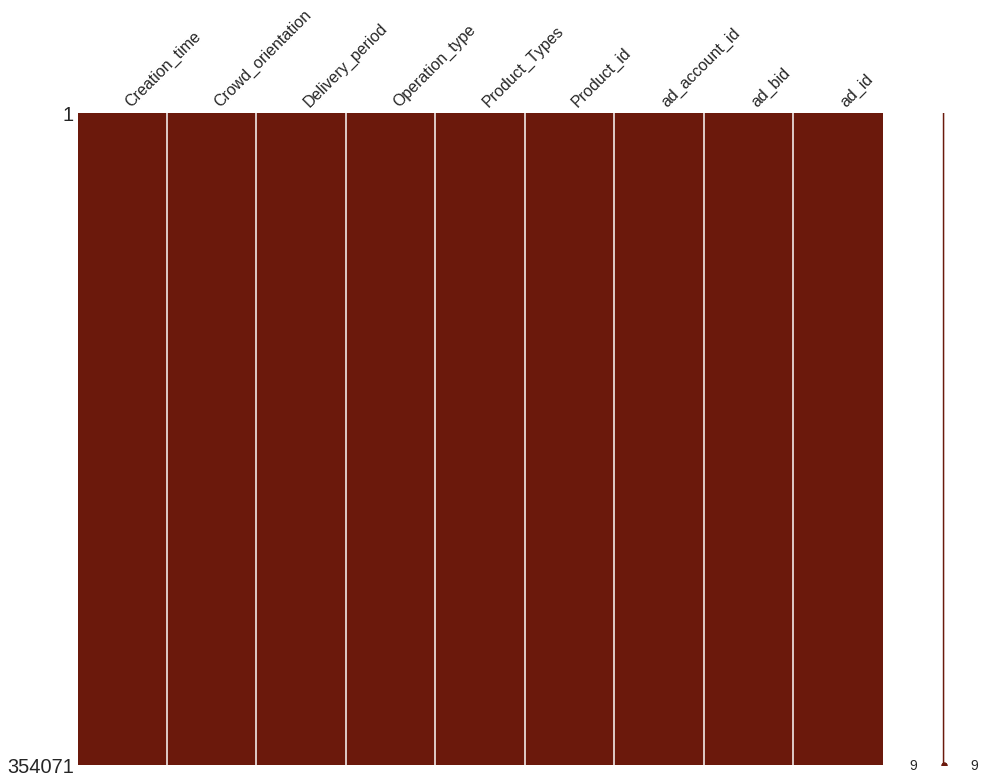

In [29]:
import missingno as msno
# Nullity or missing values by columns
msno.matrix(df=ad_data.iloc[:,:9], figsize=(16, 12), color=(0.42, 0.1, 0.05))

In [18]:
ad_data_test = ad_data
# .set_index('Creation_time')   # 根据需要看要不要执行吧吧

# 下面三行代码的参考链接
# 链接1：https://stackoverflow.com/questions/52913816/pandas-how-to-organised-dataframe-based-on-date-and-assign-new-values-to-colum
# 链接2：https://stackoverflow.com/questions/52909610/pandas-getting-first-and-last-value-from-each-day-in-a-datetime-dataframe

# def last(entry):
#     return entry['Crowd_orientation'][-1],entry['Delivery_period'][-1],entry['Product_Types'][-1],entry['Product_id'][-1], entry['ad_account_id'][-1],entry['ad_bid'][-1],entry['ad_industry_id'][-1],entry['ad_size'][-1],entry['ad_status'][-1],   
# ad_data_test = ad_data_test.groupby(ad_data_test['ad_id']).resample('D',on='Creation_time').apply(['last'])
# ad_data_test = ad_data_test[ad_data_test.ad_id.ne(ad_data_test.ad_id.shift(-1))]
ad_data_test = ad_data_test.groupby([ad_data_test.Creation_time.dt.date,ad_data_test['ad_id']]).tail(1)
# ad_data_test.resample('D')
# .groupby('ad_id').agg('last')

ad_data_test.head()
# ['Crowd_orientation','Delivery_period','Product_Types','Product_id','ad_account_id','ad_bid','ad_industry_id','ad_size','ad_status'].agg(['last']

,Creation_time,Crowd_orientation,Delivery_period,Operation_type,Product_Types,Product_id,ad_account_id,ad_bid,ad_id,ad_industry_id,ad_size,ad_status
0,2019-02-20 02:51:34,all,"281474976710655,281474976710655,28147497671065...",2,18.0,8789.0,3838.0,90,593323,117.0,64.0,1
1,2019-02-17 00:00:00,all,"281474976710655,281474976710655,28147497671065...",1,18.0,10418.0,12827.0,90,593323,117.0,36.0,0
3,2019-02-18 00:00:00,all,"281474976710655,281474976710655,28147497671065...",1,18.0,28082.0,22180.0,90,593323,117.0,36.0,1
4,2019-03-01 00:00:00,all,"281474976710655,281474976710655,28147497671065...",1,18.0,16078.0,3934.0,90,593323,117.0,54.0,1
6,2019-02-20 22:04:58,"age:217,202,837,602,935,942,638,287,5,394,536,...","281474976710655,281474976710655,28147497671065...",1,18.0,21630.0,25181.0,40,146563,117.0,36.0,1


In [19]:
ad_data_test.shape  # 354071      16238     161086

(161086, 12)

In [20]:
ad_data_test = ad_data_test[~ad_data_test['ad_status'].isin(['0'])]
ad_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62600 entries, 0 to 360791
Data columns (total 12 columns):
Creation_time        62600 non-null datetime64[ns]
Crowd_orientation    62600 non-null object
Delivery_period      62600 non-null object
Operation_type       62600 non-null int64
Product_Types        62600 non-null float64
Product_id           62600 non-null float64
ad_account_id        62600 non-null float64
ad_bid               62600 non-null object
ad_id                62600 non-null int64
ad_industry_id       62600 non-null float64
ad_size              62600 non-null float64
ad_status            62600 non-null object
dtypes: datetime64[ns](1), float64(5), int64(2), object(4)
memory usage: 6.2+ MB


In [21]:
ad_data_test.head()

,Creation_time,Crowd_orientation,Delivery_period,Operation_type,Product_Types,Product_id,ad_account_id,ad_bid,ad_id,ad_industry_id,ad_size,ad_status
0,2019-02-20 02:51:34,all,"281474976710655,281474976710655,28147497671065...",2,18.0,8789.0,3838.0,90,593323,117.0,64.0,1
3,2019-02-18 00:00:00,all,"281474976710655,281474976710655,28147497671065...",1,18.0,28082.0,22180.0,90,593323,117.0,36.0,1
4,2019-03-01 00:00:00,all,"281474976710655,281474976710655,28147497671065...",1,18.0,16078.0,3934.0,90,593323,117.0,54.0,1
6,2019-02-20 22:04:58,"age:217,202,837,602,935,942,638,287,5,394,536,...","281474976710655,281474976710655,28147497671065...",1,18.0,21630.0,25181.0,40,146563,117.0,36.0,1
8,2019-02-25 00:00:00,"age:217,202,837,602,935,942,638,287,5,394,536,...","281474976710655,281474976710655,28147497671065...",1,18.0,2936.0,20995.0,40,146563,232.0,64.0,1


In [22]:
ad_data_test = ad_data_test.drop(['Operation_type','ad_status'],axis = 1)
ad_data_test.head()

,Creation_time,Crowd_orientation,Delivery_period,Product_Types,Product_id,ad_account_id,ad_bid,ad_id,ad_industry_id,ad_size
0,2019-02-20 02:51:34,all,"281474976710655,281474976710655,28147497671065...",18.0,8789.0,3838.0,90,593323,117.0,64.0
3,2019-02-18 00:00:00,all,"281474976710655,281474976710655,28147497671065...",18.0,28082.0,22180.0,90,593323,117.0,36.0
4,2019-03-01 00:00:00,all,"281474976710655,281474976710655,28147497671065...",18.0,16078.0,3934.0,90,593323,117.0,54.0
6,2019-02-20 22:04:58,"age:217,202,837,602,935,942,638,287,5,394,536,...","281474976710655,281474976710655,28147497671065...",18.0,21630.0,25181.0,40,146563,117.0,36.0
8,2019-02-25 00:00:00,"age:217,202,837,602,935,942,638,287,5,394,536,...","281474976710655,281474976710655,28147497671065...",18.0,2936.0,20995.0,40,146563,232.0,64.0


In [23]:
ad_data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62600 entries, 0 to 360791
Data columns (total 10 columns):
Creation_time        62600 non-null datetime64[ns]
Crowd_orientation    62600 non-null object
Delivery_period      62600 non-null object
Product_Types        62600 non-null float64
Product_id           62600 non-null float64
ad_account_id        62600 non-null float64
ad_bid               62600 non-null object
ad_id                62600 non-null int64
ad_industry_id       62600 non-null float64
ad_size              62600 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 5.3+ MB


In [24]:
ad_data_test.to_csv('ad_data_new.csv',index = False)